In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.datasets import make_classification

In [3]:
X, y = make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)

<AxesSubplot:>

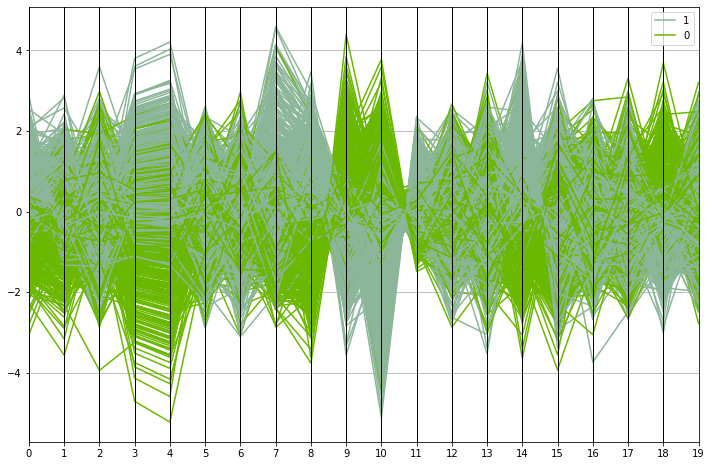

In [55]:
tmpdf = pd.DataFrame(X)
tmpdf['y'] = y
plt.figure(figsize=(12,8))
pd.plotting.parallel_coordinates(tmpdf.sample(1000), 'y')

In [6]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [7]:
clf.fit(X_train, y_train)

LogisticRegression()

In [10]:
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.876, 0.8631515151515151)

## The confusion Matrix

 A classifier will get some samples right, and some wrong. Generally we see which ones it gets right and which ones it gets wrong on the test set. There,

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix from these which lookslike this:

![hwimages](images/confusionmatrix.pdf)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`

In [140]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[43286,  6189],
       [ 7359, 42166]])

Given these definitions, we typically calculate a few metrics for our classifier. First, the **True Positive Rate**:

$$TPR = Recall = \frac{TP}{OP} = \frac{TP}{TP+FN},$$

also called the Hit Rate: the fraction of observed positives (1s) the classifier gets right, or how many true positives were recalled. Maximizing the recall towards 1 means keeping down the false negative rate. In a classifier try to find cancer patients, this is the number we want to maximize.

The **False Positive Rate** is defined as

$$FPR = \frac{FP}{ON} = \frac{FP}{FP+TN},$$

also called the False Alarm Rate, the fraction of observed negatives (0s) the classifier gets wrong. In general, you want this number to be low. Instead, you might want to maximize the
**Precision**,which tells you how many of the predicted positive(1) hits were truly positive

$$Precision = \frac{TP}{PP} = \frac{TP}{TP+FP}.$$

Finally the **F1** score gives us the Harmonic Score of Precision and Recall. Many analysts will try and find a classifier that maximizes this score, since it tries to minimize both false positives and false negatives simultaneously, and is thus a bit more precise in what it is trying to do than the accuracy.

$$F1 =  \frac{2*Recall*Precision}{Recall + Precision}$$

However, in a case like that of a cancer classifier, we will wish to minimize false nagatives at the expense of false positives: it is ok to send perfectly healthy patients for cancer folloup if that is the price we must pay for not missing any sick ones.

`scikit-learn` helpfully gives us a classification report with all these numbers

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     49475
           1       0.87      0.85      0.86     49525

    accuracy                           0.86     99000
   macro avg       0.86      0.86      0.86     99000
weighted avg       0.86      0.86      0.86     99000



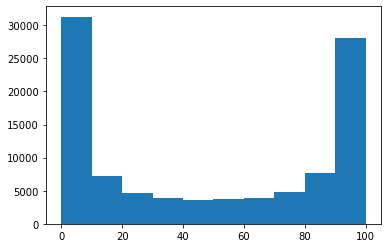

In [12]:
plt.hist(clf.predict_proba(X_test)[:,1]*100);

Probabilistic models  have the nice property that they compute probabilities of a particular classification -- the predict_proba and predict_log_proba methods  compute these probabilities.

You should always assess whether these probabilities are calibrated -- that is, whether a prediction made with a confidence of x% is correct approximately x% of the time.

Let's make a plot to assess model calibration. Schematically, we want something like this:

![](http://i.imgur.com/ea5B6zr.png)

In [15]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import  calibration_curve

prob_pos = clf.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=20)
clf_score = brier_score_loss(y_test, prob_pos, pos_label=y_test.max())

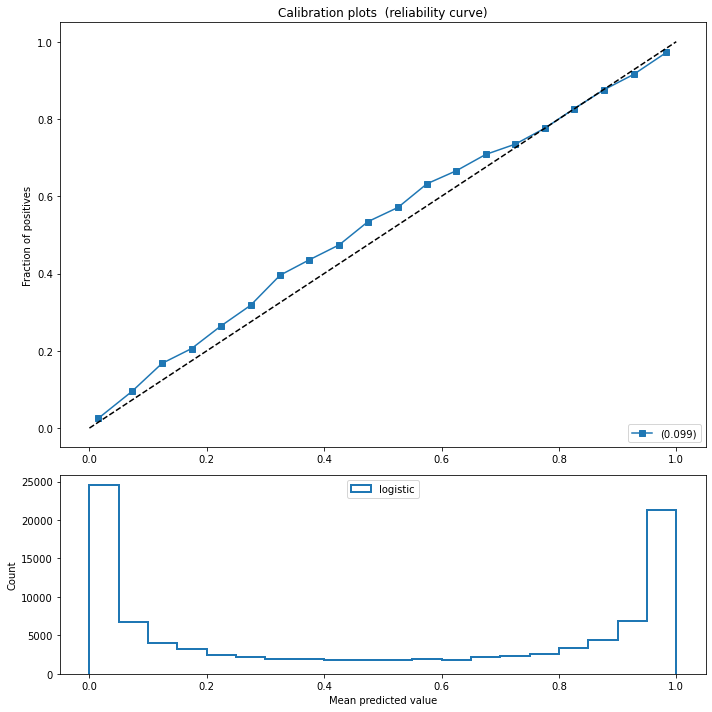

In [16]:
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label="(%1.3f)" % (clf_score))
ax1.plot([0,1], [0,1], "k--")
ax2.hist(prob_pos, range=(0, 1), bins=20, label="logistic",
         histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

In [157]:
indices = np.random.choice(99000, size=5000)

Text(0, 0.5, 'margin = $(2y -1)\\times (p-0.5)$')

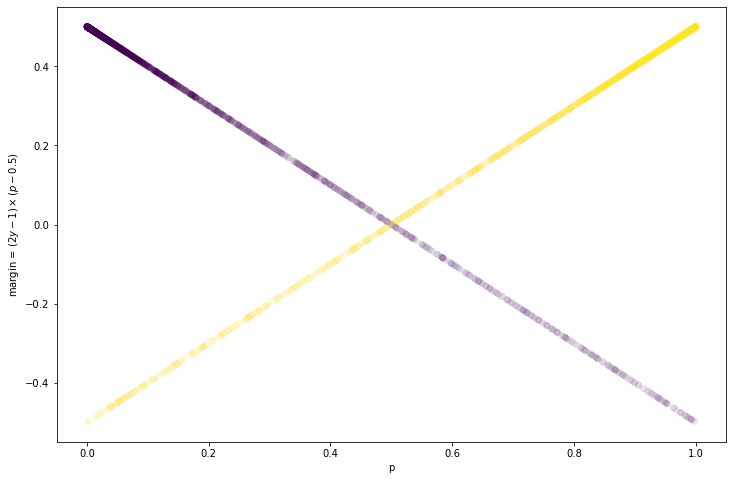

In [159]:
plt.figure(figsize=(12, 8))
margins = (prob_pos[indices]-0.5)*(2*y_test[indices]-1)
plt.scatter(prob_pos[indices], margins, c=y_test[indices], alpha=0.05)
plt.xlabel('p')
plt.ylabel(r"margin = $(2y -1)\times (p-0.5)$")


In [184]:
y_test[indices]

array([1, 0, 1, ..., 1, 1, 1])

(0.0, 50.0)

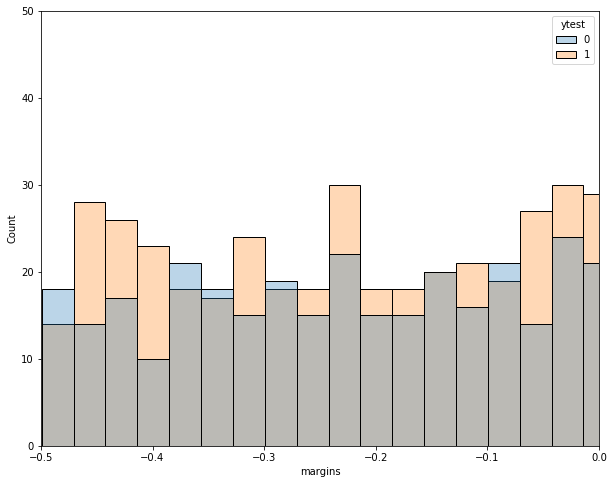

In [193]:
import seaborn as sns
plt.figure(figsize=(10, 8))
data = pd.DataFrame(dict(margins=margins, ytest = y_test[indices]))
sns.histplot(data=data, x='margins', hue='ytest', alpha=0.3)
plt.xlim(-0.5, 0)
plt.ylim(0, 50)

In [160]:
loglosses = - (y_test[indices]*np.log(prob_pos[indices]) + \
    (1-y_test[indices])*np.log(1-prob_pos[indices]))

Text(0, 0.5, 'logloss = - $(ylog p _(1-y)log(1-p)$')

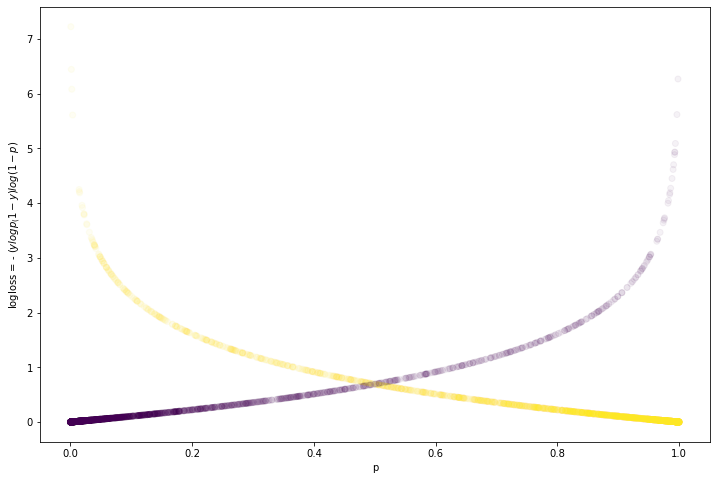

In [161]:
plt.figure(figsize=(12, 8))
plt.scatter(prob_pos[indices], loglosses, c=y_test[indices], alpha=0.05)
plt.xlabel('p')
plt.ylabel(r"logloss = - $(ylog p _(1-y)log(1-p)$")

Text(0, 0.5, 'brier scores = - $(y-p)^2$')

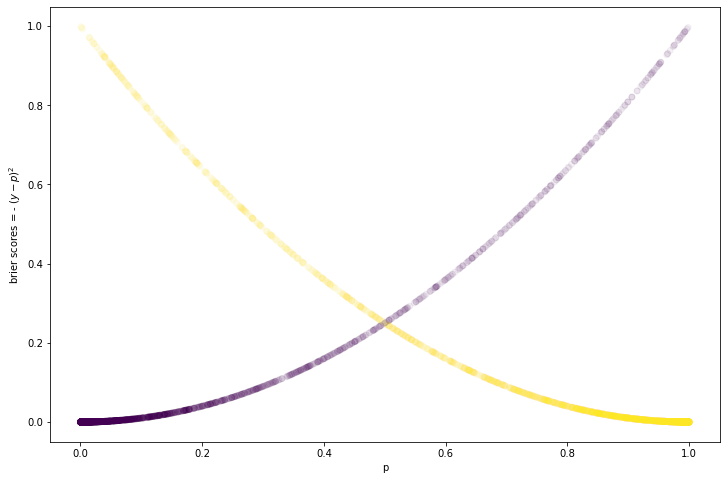

In [162]:
plt.figure(figsize=(12, 8))
briers = (y_test[indices]- prob_pos[indices]) **2
plt.scatter(prob_pos[indices], briers, c=y_test[indices], alpha=0.05)
plt.xlabel('p')
plt.ylabel(r"brier scores = - $(y-p)^2$")

In [143]:
def calib(est, X_test, y_test, label):
    prob_pos = est.predict_proba(X_test)[:, 1]
    fraction_of_positive, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=20)
    clf_score = brier_score_loss(y_test, prob_pos, pos_label=y_test.max())
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(mean_predicted_value, fraction_of_positive, "s-",
             label="(%1.3f)" % (clf_score))
    ax1.plot([0,1], [0,1], "k--")
    ax2.hist(prob_pos, range=(0, 1), bins=20, label=label,
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    return est, prob_pos

In [144]:
from sklearn.naive_bayes import GaussianNB

In [145]:
clfgnb = GaussianNB() #DecisionTreeClassifier(min_samples_leaf=25)
clfgnb.fit(X_train, y_train)
clfgnb.score(X_train, y_train), clfgnb.score(X_test, y_test)

(0.869, 0.8650606060606061)

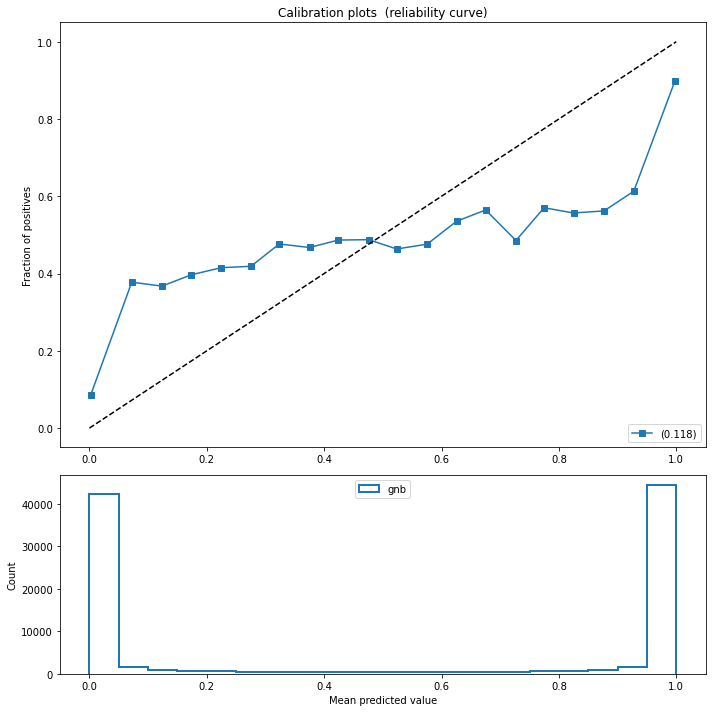

In [146]:
_, ppgnb = calib(clfgnb, X_test, y_test, label="gnb")

Text(0, 0.5, 'brier scores = $(y-p)^2$')

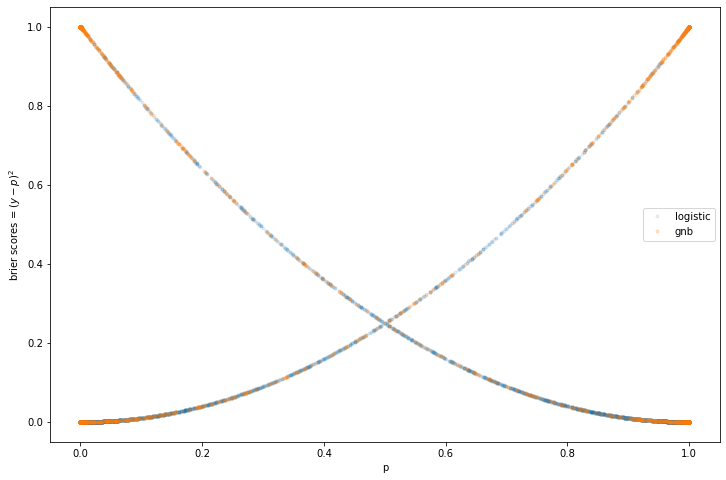

In [166]:
plt.figure(figsize=(12, 8))
briers = (y_test[indices]- prob_pos[indices]) **2
briers_gnb = (y_test[indices]- ppgnb[indices]) **2
plt.plot(prob_pos[indices], briers, '.', alpha=0.1, label="logistic")
plt.plot(ppgnb[indices], briers_gnb, '.', alpha=0.2, label="gnb")
plt.legend();
plt.xlabel('p')
plt.ylabel(r"brier scores = $(y-p)^2$")

In [150]:
from sklearn.ensemble import GradientBoostingClassifier

In [151]:
boost = GradientBoostingClassifier(learning_rate=0.01, 
                                   n_estimators=125, max_depth=2)

In [152]:
boost.fit(X_train, y_train)
boost.score(X_train, y_train), boost.score(X_test, y_test)

(0.885, 0.8677171717171717)

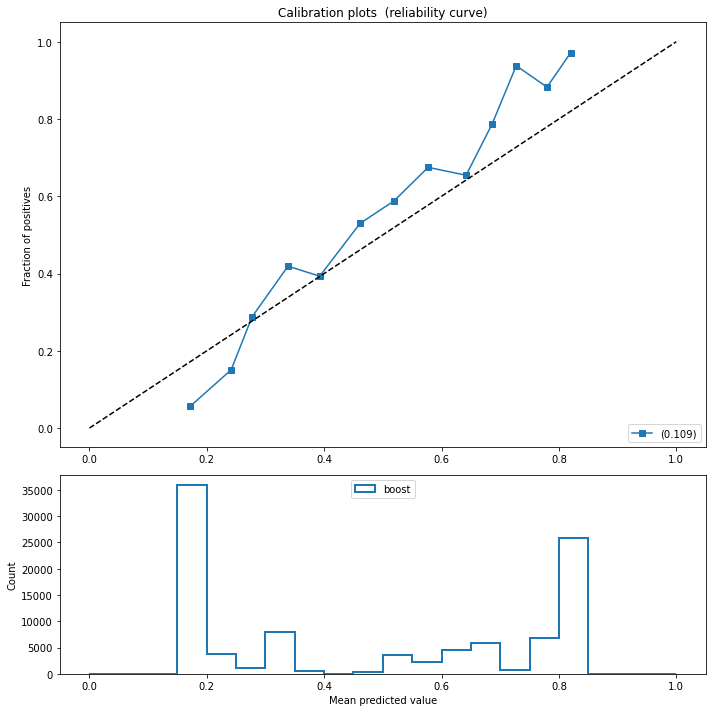

In [154]:
_, ppboost = calib(boost, X_test, y_test, "boost")

Text(0, 0.5, 'brier scores = $(y-p)^2$')

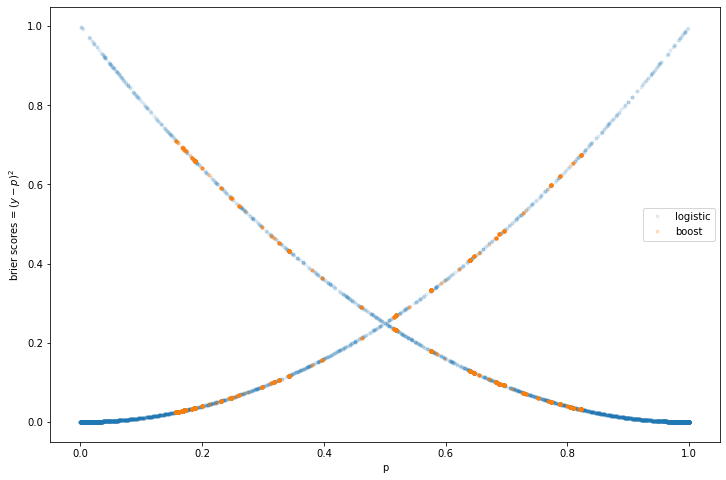

In [168]:
plt.figure(figsize=(12, 8))
briers = (y_test[indices]- prob_pos[indices]) **2
briers_boost = (y_test[indices]- ppboost[indices]) **2
plt.plot(prob_pos[indices], briers, '.', alpha=0.1, label="logistic")
plt.plot(ppboost[indices], briers_boost, '.', alpha=0.2, label="boost")
plt.legend();
plt.xlabel('p')
plt.ylabel(r"brier scores = $(y-p)^2$")

In [95]:
from sklearn.calibration import CalibratedClassifierCV

In [103]:
# Calibrated with sigmoid calibration
sigmoid = CalibratedClassifierCV(GradientBoostingClassifier(learning_rate=0.01, 
                                   n_estimators=125, max_depth=2), 
                                 cv=5, 
                                 method='sigmoid')

In [104]:
sigmoid.fit(X_train, y_train)
sigmoid.score(X_train, y_train), sigmoid.score(X_test, y_test)

(0.885, 0.8677979797979798)

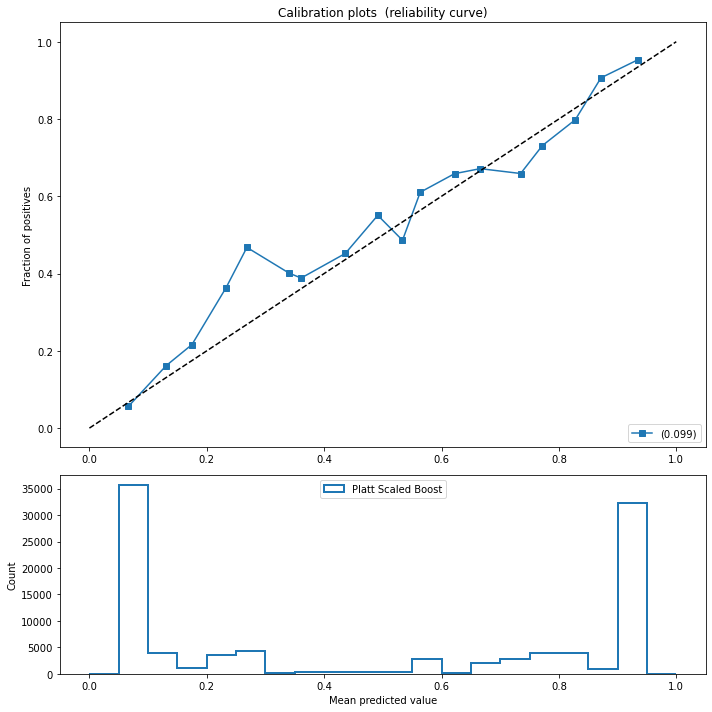

In [172]:
_, ppsig = calib(sigmoid, X_test, y_test, "Platt Scaled Boost")

Text(0, 0.5, 'brier scores = $(y-p)^2$')

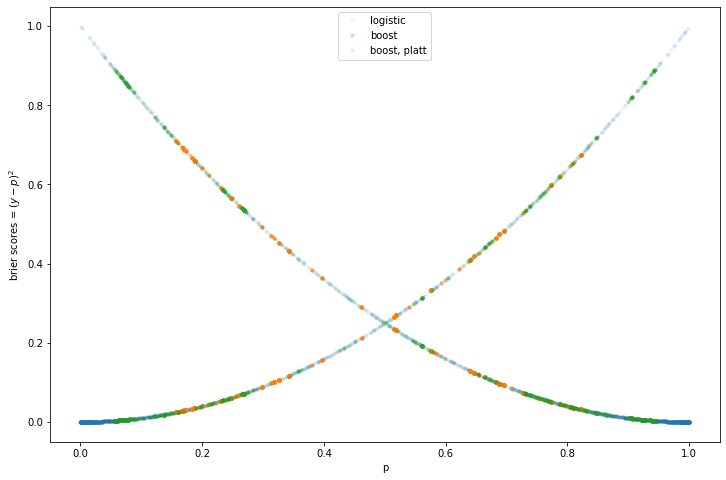

In [179]:
plt.figure(figsize=(12, 8))
briers = (y_test[indices]- prob_pos[indices]) **2
briers_sig = (y_test[indices]- ppsig[indices]) **2
plt.plot(prob_pos[indices], briers, '.', alpha=0.05, label="logistic")
plt.plot(ppboost[indices], briers_boost, '.', alpha=0.3, label="boost")
plt.plot(ppsig[indices], briers_sig, '.', alpha=0.1, label="boost, platt")
plt.legend();
plt.xlabel('p')
plt.ylabel(r"brier scores = $(y-p)^2$")

In [106]:
isotonic = CalibratedClassifierCV(GaussianNB(), cv=5, method='isotonic')
isotonic.fit(X_train, y_train)
isotonic.score(X_train, y_train), sigmoid.score(X_test, y_test)

(0.882, 0.8677979797979798)

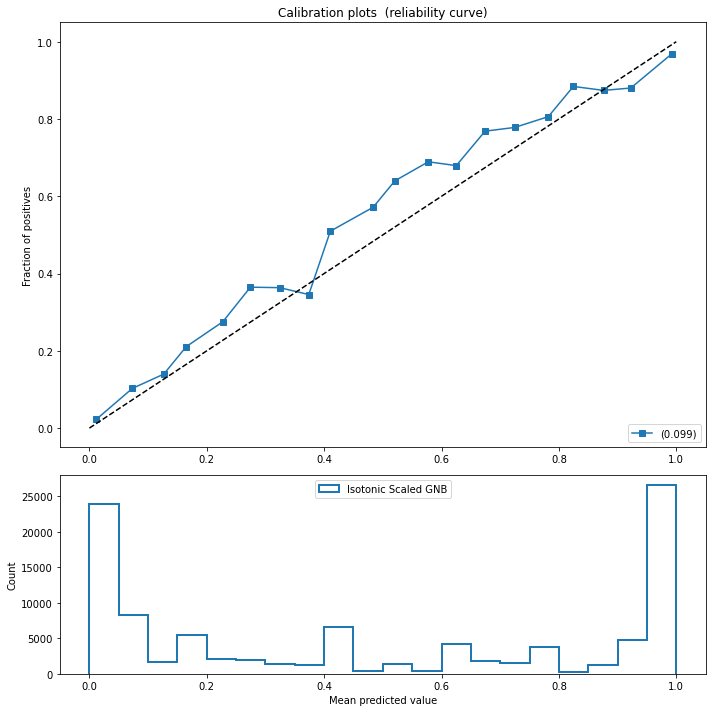

In [171]:
_, ppiso = calib(isotonic, X_test, y_test, "Isotonic Scaled GNB")